<!DOCTYPE html>
<html lang="en">
    <head>
        <meta charset="UTF-8" />
        <meta http-equiv="X-UA-Compatible" content="IE=edge" />
        <meta name="viewport" content="width=device-width, initial-scale=1.0" />
        <title>UAS NLP</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                background-color: #f0f0f0;
                margin: 0;
                padding: 0;
            }
            .container {
                text-align: center;
                margin-top: 50px;
            }
            h1 {
                color: #fff; /* Adjusted color for dark mode */
                font-size: 36px;
                margin-bottom: 10px;
            }
            h2 {
                color: #ccc; /* Adjusted color for dark mode */
                font-size: 28px;
                margin-bottom: 20px;
            }
            .members {
                font-size: 20px;
                line-height: 1.6;
                margin-top: 20px;
            }
            .member {
                display: block;
                margin-bottom: 10px;
            }
        </style>
    </head>
    <body>
        <div class="container">
            <h1>Ujian Akhir Semester</h1>
            <h2>IBDA3322 / Natural Language Processing</h2>
            <h2>English To Indonesia Machine Translation Using mBART-50</h2>
            <p class="members">
                <span class="member">Jennifer Atalya (202000208)</span>
                <span class="member">Renata Valencia (202001021)</span>
                <span class="member">Stefannus Christian (202000138)</span>
            </p>
        </div>
    </body>
</html>

![alt text](assets/definisi_m_bart.png)

# Import Libraries (Ren)

In [1]:
import warnings
warnings.filterwarnings('ignore')
# Import libraries
from transformers import (
    MBart50TokenizerFast,
    MBartForConditionalGeneration,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
)
import csv
import re
from natsort import natsorted
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import evaluate
from datasets import load_dataset, load_from_disk

# Define Some Global Variables

In [2]:
# Define training parameters
# Set to True to train the model
TRAIN: bool = False

# Random seed for consistent
SEED = 42

# Define model and data paths
MODEL_PATH = "model/mbart-large-50-one-to-many-mmt-finetuned-en-to-id"

In [3]:
# Set to True if not running on RTX4080 machine (will reduce number of training data to fine tuned)
IS_RUNNING_ON_LOCAL_LAPTOP = False
if IS_RUNNING_ON_LOCAL_LAPTOP:
    print("RUNNING ON LOCAL LAPTOP!")
else:
    print("RUNNING ON RTX4080!")

if TRAIN:
    print("RUNNING IN TRAIN MODE!")
else:
    print("RUNNING ON TEST MODE!")

RUNNING ON RTX4080!
RUNNING ON TEST MODE!


![Alt text](./assets/table_3_paper.png)

![Alt text](./assets/dataset_used_in_mbart.png)


# Load Raw Datasets

In [4]:
# Load the dataset that will be used to fine tuned the model and save_to_disk (for faster loading in the next run session)

# Path to store the raw_datasets that will be used for fine tuning the model
UAS_CACHE_BASE_PATH = "./uas_cache/"
RAW_DATASETS_FILENAME = "raw_datasets.hf"
RAW_DATASETS_PATH = os.path.join(UAS_CACHE_BASE_PATH, RAW_DATASETS_FILENAME)

# Check kalo dia udah pernah disimpen ato belom, kalo belom ya di simpen
if not os.path.exists(RAW_DATASETS_PATH):
    raw_datasets = load_dataset("Helsinki-NLP/opus-100", "en-id") # 1 juta baris
    # save ke cache gitu biar next run dia cepet
    raw_datasets.save_to_disk(RAW_DATASETS_PATH)

# load dataset nya yang udah disimpen tadi (kalo gak disimpen setiap kali di run bisa 12 detik karena dataset nya besar (1 juta baris))
else:
    raw_datasets = load_from_disk(RAW_DATASETS_PATH)

# View dataset information
display(raw_datasets)

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 1000000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})

In [5]:
print(raw_datasets['train'][824])
print(raw_datasets['validation'][624])

{'translation': {'en': '- Are you done?', 'id': '- Apa kau sudah selesai?'}}
{'translation': {'en': '- No whipped cream.', 'id': '- Tidak krim kocok'}}


In [6]:
# Specify the model to be used from Hugging Face model hub
model_mbart = "facebook/mbart-large-50-one-to-many-mmt" # pretrained model yang pengen di fine-tuned

# Load the tokenizer for the specified model. This tokenizer is responsible for converting text into tokens.
# 'src_lang' and 'tgt_lang' specify the source and target languages for translation.
tokenizer = MBart50TokenizerFast.from_pretrained(
    model_mbart, src_lang="en_XX", tgt_lang="id_ID"
)

In [21]:
# Function to remove extra spaces from the text
# Data preprocessing
def remove_extra_spaces(text: str) -> str:
    # Use regular expression to replace multiple spaces with a single space and strip leading/trailing spaces
    cleaned_text = re.sub(' +', ' ', text)
    return cleaned_text.strip()


SOURCE_LANG = "en"  # Source language: English
TARGET_LANG = "id"  # Target language: Indonesian
# Transformer models, like MBart, have memory requirements that scale # quadratically with the sequence length. Setting maximum lengths helps # to manage and limit memory usage, ensuring that the training process # can fit within the available hardware resources (e.g., GPU memory).
# Computational Efficiency:
# Limiting the sequence length can significantly speed up training and # inference. Processing shorter sequences reduces the amount of # computation required per batch, leading to faster training times.
# Standardization:
# Standardizing the sequence lengths helps in creating uniform batches. # This is important for efficient parallel processing on GPUs. Batching # sequences of different lengths can lead to inefficiencies due to # padding and variable computation times.
MAX_INPUT_LENGTH = 128  # Maximum length of input sequence
MAX_TARGET_LENGTH = 128  # Maximum length of target sequence

# Preprocessing function to prepare the dataset for the model
def preprocess_function(examples):
    """
    Preprocess data examples for model training:

    - Remove extra spaces from both source and target language text.
    - Tokenize the source and target texts using the tokenizer.

    Args:
        examples (dict): A dictionary containing 'translation' pairs of source and target language text.

    Returns:
        dict: A dictionary with tokenized inputs and corresponding labels.
        {
            "input_ids": List of tokenized input sentences,
            "attention_mask": List of attention masks for input sentences,
            "labels": List of tokenized target sentences
        }
    """
    # {'translation': {'en': '- Are you done?', 'id': '- Apa kau sudah selesai?'}}


    # Add a prefix to the source sentences and clean extra spaces
    inputs = [remove_extra_spaces(ex[SOURCE_LANG]) for ex in examples["translation"]]
    # Clean extra spaces in the target sentences
    targets = [remove_extra_spaces(ex[TARGET_LANG]) for ex in examples["translation"]]
    #inputs = [
    #"translate English to Indonesian: This is an example sentence.",
    #"translate English to Indonesian: Another sentence for testing."
    # ]
    # targets = [
    #    "Ini adalah sebuah kalimat contoh.",
    #    "Kalimat lain untuk pengujian."
    #]

    # Tokenize the inputs with a maximum length and apply truncation if necessary
    model_inputs = tokenizer(inputs, max_length=MAX_INPUT_LENGTH, truncation=True)

    # Tokenize the targets within a context where the tokenizer's target language is used

    #Byte-Pair Encoding (BPE)
    #Byte-Pair Encoding is a subword tokenization algorithm that splits text into subword     #units, allowing for better handling of rare words and a more efficient vocabulary. It     #works by iteratively merging the most frequent pairs of bytes (characters or character     #sequences) until a specified vocabulary size is reached.
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=MAX_TARGET_LENGTH, truncation=True)

    # Add the tokenized labels to the model inputs
    model_inputs["labels"] = labels["input_ids"]

    #model_inputs = {
    #"input_ids": [
    #    [0, 314, 104, 5, 21, 4, 65, 230, 8, 12, 10, 15, 55, 2],
    #    [0, 314, 104, 5, 21, 4, 65, 48, 19, 24, 10, 32, 2]
    #],
    #"attention_mask": [
    #    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    #    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    #],
    #"labels": [
    #    [0, 130, 5, 9, 121, 44, 7, 17, 41, 2],
    #    [0, 203, 45, 12, 56, 2]
    #]
    #}


    # Return the processed model inputs with tokenized inputs and labels
    return model_inputs

# Preprocess dataset
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)
print(tokenized_datasets["train"][824])

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'translation': {'en': '- Are you done?', 'id': '- Apa kau sudah selesai?'}, 'input_ids': [250004, 20, 15901, 398, 16940, 32, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1], 'labels': [250032, 20, 9795, 5836, 2491, 50642, 32, 2]}


![alt text](assets/why_bpe.png)

# Jen

In [8]:
# Split datasets into train and validation sets
# train dataset --> 1 million rows (very computationally expensive)
train_tokenized_dataset = tokenized_datasets["train"]
# eval dataset --> to avoid overfitting
eval_tokenized_dataset = tokenized_datasets["validation"]

number_of_train_tokenized_data = len(train_tokenized_dataset)
number_of_eval_tokenized_data = len(eval_tokenized_dataset)
print(f"Number of train tokenized data: {number_of_train_tokenized_data}")
print(f"Number of eval tokenized data: {number_of_eval_tokenized_data}\n")

# train dataset -> 1 juta baris
# PERCENTAGE_OF_TRAIN_TOKENIZED_DATA_TO_FINEDTUNED = 50%
# 50% dari 1 juta baris = 500 ribu baris

# Harus di shuffle biar dia random (gausa random sih, tapi karena awal2 dia kata nya pendek2, jadi biar data nya bervariasi aja)
# Kenapa pake data validation semuanya

if not IS_RUNNING_ON_LOCAL_LAPTOP:
    PERCENTAGE_OF_TRAIN_TOKENIZED_DATA_TO_FINEDTUNED = 0.5
    # Limit data used for fine-tuning
    NUMBER_OF_TRAINING_DATA_TO_FINETUNED = int(
        PERCENTAGE_OF_TRAIN_TOKENIZED_DATA_TO_FINEDTUNED * number_of_train_tokenized_data
    )
    shuffled_eval_dataset = eval_tokenized_dataset.shuffle(seed=SEED)

else:
    NUMBER_OF_TRAINING_DATA_TO_FINETUNED = 128
    shuffled_eval_dataset = eval_tokenized_dataset.shuffle(seed=SEED).select(
        range(NUMBER_OF_TRAINING_DATA_TO_FINETUNED)
    )

# Select a small subset of data for fine-tuning (for faster training)
small_train_dataset = train_tokenized_dataset.shuffle(
    seed=SEED).select(range(NUMBER_OF_TRAINING_DATA_TO_FINETUNED))

print(f"Number of small_train_dataset {len(small_train_dataset)}")
print(f"Number of shuffled_eval_dataset {len(shuffled_eval_dataset)}")

Number of train tokenized data: 1000000
Number of eval tokenized data: 2000

Number of small_train_dataset 500000
Number of shuffled_eval_dataset 2000


In [9]:
# Load pre-trained model (make sure to use 'cuda' for GPU training)
model = MBartForConditionalGeneration.from_pretrained(model_mbart).cuda()

In [24]:
# Freeze all layers except the decoder's last layers
# Secara garis besar, encoder yang coba mengerti input dan konteks input. Decoder yang keluarin hasil translasi. Aku bekuin encoder karena modelnya sudah dilatih dengan dataset yang sudah besar dan bervariasi, jadi modelnya udah pintar untuk mengerti konteks kalimat dan kata2. Jadi yang di train hanya decoder supaya bisa mengeluarkan output khusus inggris ke indonesia dengan lebih baik

# mBART ini di latih di 50 bahasa --> dia bisa dipake buat summarization juga bukan translation doank
# Encoder --> yang ngerti bahasa inggris nya (konteks nya dll --> ini udah bagus, input coba mempelajari Bahasa)
# Decoder --> dia harus tau dikeluarin nya kek gimana (translate nya) --> dia harus dilatih biar dia tau kalau kita pengen keluarin translate ke indo (bukan summarize atau dll)

# Kenapa yang di freeze cuman encoder:

count = 0

for param in model.get_encoder().parameters():

    param.requires_grad = False

    count += 1

print(f"freezes {count} layers")

freezes 198 layers


In [11]:
# Define training hyperparameters
# Kenapa pake learning_rate 2e-5, karena ngikutin dokumentasi (ini kan hyperparameter jadi nilai nya yang dicoba2)
# pengaruh learning rate tinggi: susah konvergen nyaa
# pengaruh learning rate rendah: lama hasil training nyaa

# kenapa pake batch size 16: karena GPU nya ga kuat kalo pakai 32, 64, 128 ,256, kenapa ga pake default 8 karena nanti training nya kelamaan
# higher batch size means faster training speed but lower accuracy
# lower batch size means slower training speed but higher accuracy

# num epochs kenapa pakai 5: ga ada alasan sih, ini emang hyperparameter (coba - coba aja), kenapa ga 10 gitu karena kelamaan nanti training nya, kenapa ga pake 3 aja karena jelek angkanya

hyperparameters = {
    'learning_rate': 2e-5, # Default is 5e-5
    'batch_size': 16, # Default is 8
    'num_epochs': 5 # Default is 3
}

args = Seq2SeqTrainingArguments(
    # Create a name for your fine-tuned model
    MODEL_PATH,
    # Evaluate the model after every epoch
    evaluation_strategy="epoch",
    # Save the model after every epoch
    save_strategy="epoch",
    # Set learning rate from hyperparameters
    learning_rate=hyperparameters["learning_rate"],
    # Batch size for training on a single device
    per_device_train_batch_size=hyperparameters["batch_size"],
    # Batch size for evaluation on a single device
    per_device_eval_batch_size=hyperparameters["batch_size"],
    # Weight decay to avoid overfitting
    weight_decay=0.01,  # Default is 0
    # Limit number of saved models during training
    save_total_limit=hyperparameters["num_epochs"],
    # Set the total number of training epochs
    num_train_epochs=hyperparameters["num_epochs"],
    # Generate text with beam search during evaluation
    predict_with_generate=True,
)

![alt text](assets/penjelasasn_batch_size.png)

In [12]:
# Create a data collator to prepare batches for training and evaluation
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [13]:
metric = evaluate.load('sacrebleu')
rouge = evaluate.load('rouge')

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them. --> ini ga faham, cuman ngikut dokumentasi
    labels = np.where(labels!= -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    # compute BLEU score
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)

    # Compute rouge
    rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels)

    result = {'bleu' : result['score']}
    result["rouge1"] = rouge_result["rouge1"]
    result["rouge2"] = rouge_result["rouge2"]
    result["rougeL"] = rouge_result["rougeL"]
    result["rougeLsum"] = rouge_result["rougeLsum"]

    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [14]:
# Path to store the results of val_loss, bleu score and rouge score per epoch in a csv file
TRAINING_RESULTS_DIRECTORY_BASE_PATH = "./training_results/"
TRAINING_RESULTS_FILENAME = "training_results.csv"
TRAINING_RESULTS_PATH = os.path.join(TRAINING_RESULTS_DIRECTORY_BASE_PATH, TRAINING_RESULTS_FILENAME)

# Filename to store the model evaluation results like bleu, rouge, and val loss score
LOG_RESULTS_FILENAME = "log.pkl"
LOG_RESULTS_PATH = os.path.join(
    TRAINING_RESULTS_DIRECTORY_BASE_PATH, LOG_RESULTS_FILENAME
)

print(f"Will save training results csv to {TRAINING_RESULTS_PATH}")
print(
    f"Will save log results (log_history, bleu_log, rouge1_log, rouge2_log, rougeL_log, rougeLsum_log, eval_log) to {LOG_RESULTS_PATH}"
)

if not os.path.exists(TRAINING_RESULTS_PATH):
    os.makedirs(TRAINING_RESULTS_PATH)

if TRAIN:
    trainer = Seq2SeqTrainer(
        model,
        args,
        train_dataset=small_train_dataset,
        eval_dataset=shuffled_eval_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    trainer.train()

    trainer.save_model(MODEL_PATH)

    log_history = pd.DataFrame(trainer.state.log_history)
    bleu_log = log_history["eval_bleu"].dropna().to_list()
    eval_log = log_history["eval_loss"].dropna().to_list()
    rouge1_log = log_history["eval_rouge1"].dropna().to_list()
    rouge2_log = log_history["eval_rouge2"].dropna().to_list()
    rougeL_log = log_history["eval_rougeL"].dropna().to_list()
    rougeLsum_log = log_history["eval_rougeLsum"].dropna().to_list()

    # Save the variables using pickle
    with open(LOG_RESULTS_PATH, "wb") as f:
        pickle.dump((log_history, bleu_log, rouge1_log, rouge2_log, rougeL_log, rougeLsum_log, eval_log), f)

else:
    # Load the saved variables using pickle
    with open(LOG_RESULTS_PATH, "rb") as f:
        log_history, bleu_log, rouge1_log, rouge2_log, rougeL_log, rougeLsum_log, eval_log = pickle.load(f)

Will save training results csv to ./training_results/training_results.csv
Will save log results (log_history, bleu_log, rouge1_log, rouge2_log, rougeL_log, rougeLsum_log, eval_log) to ./training_results/log.pkl


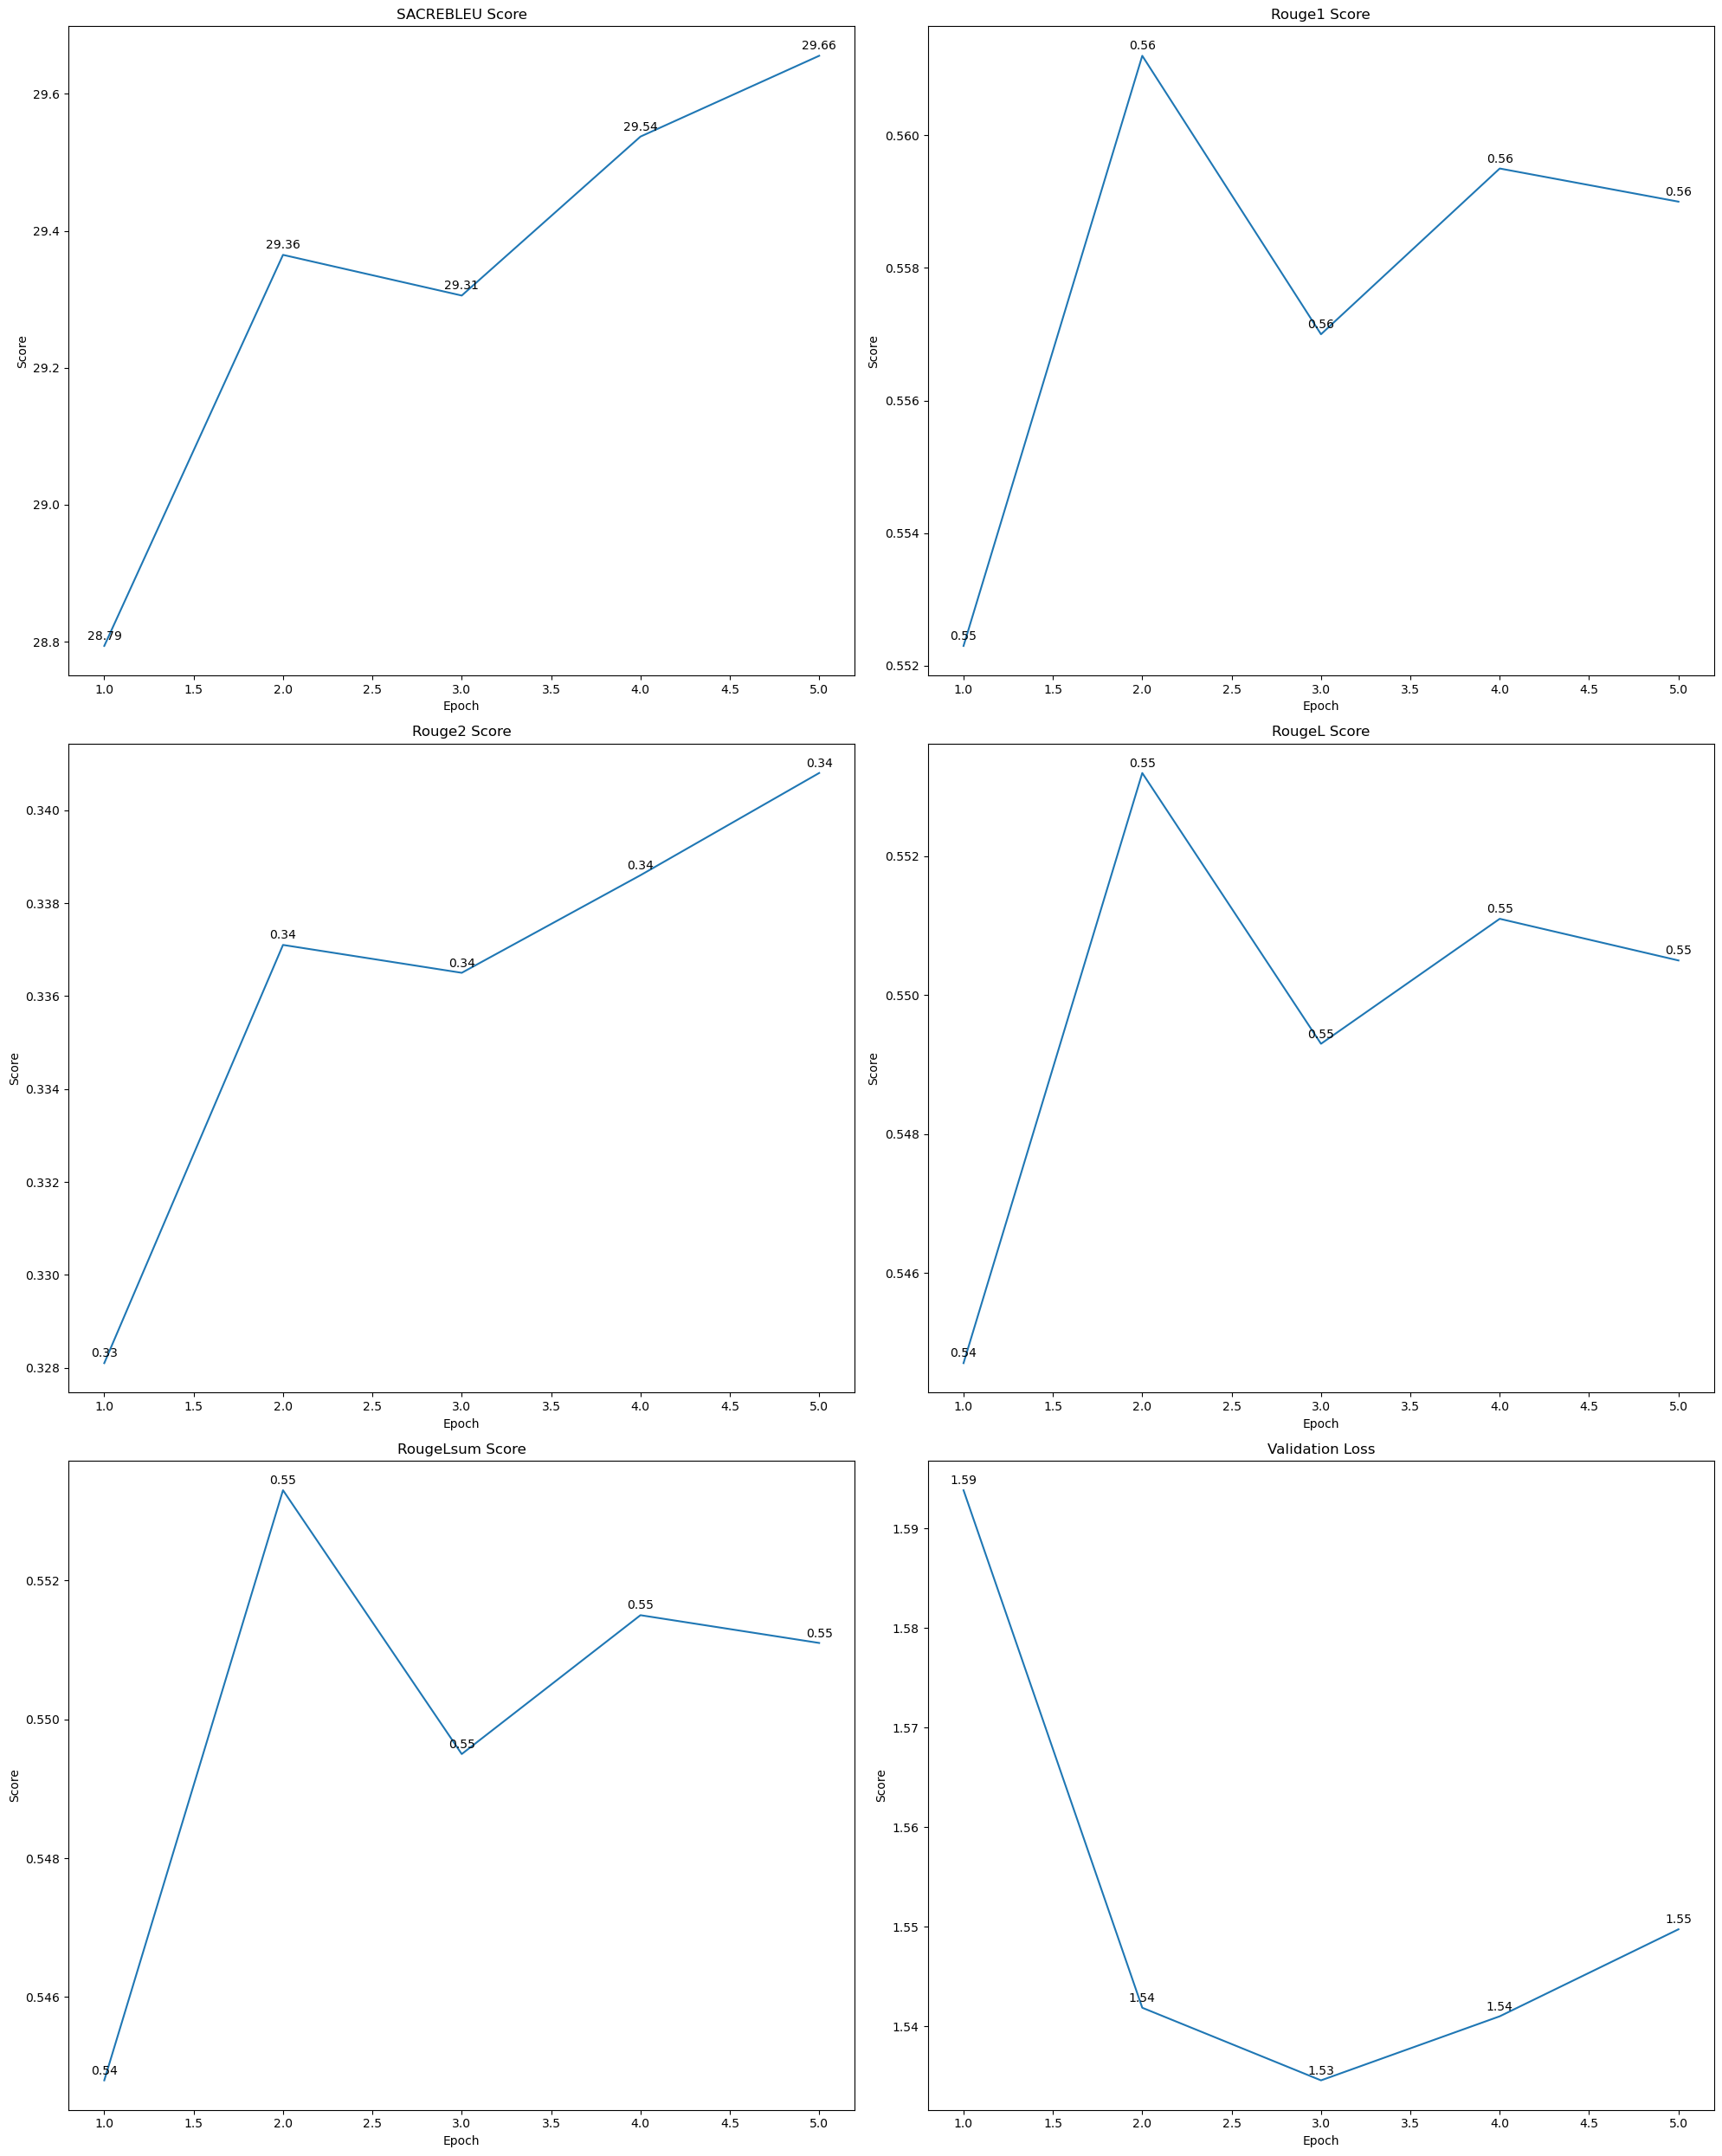

In [15]:
# Function to plot subplots and annotate values
def plot_subplot(ax, position, data, title, xlabel, ylabel):
    plt.subplot(3, 2, position)
    plt.plot(range(1, len(data) + 1), data, label=title)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # Annotate values on the plot
    for i, value in enumerate(data):
        plt.annotate(
            f"{value:.2f}",
            (i + 1, value),
            textcoords="offset points",
            xytext=(0, 5),
            ha="center",
        )


# Read the data from the CSV file
df = pd.read_csv("training_results/training_results.csv")

# Extracting data from the dataframe
bleu_log = df["BLEU"].tolist()
rouge1_log = df["rouge1"].tolist()
rouge2_log = df["rouge2"].tolist()
rougeL_log = df["rougeL"].tolist()
rougeLsum_log = df["rougeLsum"].tolist()
eval_log = df["validation_loss"].tolist()

fig, ax = plt.subplots(3, 2, figsize=(20, 25))

# Data and titles for subplots
plots_info = [
    (1, bleu_log, "SACREBLEU Score"),
    (2, rouge1_log, "Rouge1 Score"),
    (3, rouge2_log, "Rouge2 Score"),
    (4, rougeL_log, "RougeL Score"),
    (5, rougeLsum_log, "RougeLsum Score"),
    (6, eval_log, "Validation Loss"),
]

# Plot each subplot using the function
for position, data, title in plots_info:
    plot_subplot(ax, position, data, title, "Epoch", "Score")

plt.tight_layout()
plt.show()

![alt text](assets/bleu_score.png)

![alt text](assets/bleu.png)

![alt text](assets/rouge.png)

# Stef

In [16]:
rows = []
for i in range(len(bleu_log)):
    row = {
        'Epoch': i+1,
        'BLEU': bleu_log[i],
        'rouge1': rouge1_log[i],
        'rouge2': rouge2_log[i],
        'rougeL': rougeL_log[i],
        'rougeLsum': rougeLsum_log[i],
        'validation_loss': eval_log[i],
    }
    rows.append(row)

# Define the fieldnames for the CSV file
fieldnames = [
    "Epoch",
    "BLEU",
    "rouge1",
    "rouge2",
    "rougeL",
    "rougeLsum",
    "validation_loss",
]

# Write the rows to a CSV file
with open(TRAINING_RESULTS_PATH, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for row in rows:
        writer.writerow(row)

In [17]:
def find_best_checkpoint(csv_file, checkpoint_dirs):
    # Read the CSV file and find the index of the row with the highest BLEU score
    with open(csv_file, "r") as file:
        reader = csv.DictReader(file)
        max_bleu = -1
        best_epoch = -1

        for row in reader:
            bleu_score = float(row["BLEU"])
            epoch = int(row["Epoch"])
            if bleu_score > max_bleu:
                max_bleu = bleu_score
                best_epoch = epoch

    # Calculate zero-based index of the best epoch
    best_epoch_index = best_epoch - 1

    # Get the corresponding checkpoint directory
    checkpoint = checkpoint_dirs[best_epoch_index]

    return checkpoint

# Path to store best-checkpoint path
BEST_CHECKPOINT_FILENAME = "best_checkpoint.pkl"
BEST_CHECKPOINT_PATH = os.path.join(UAS_CACHE_BASE_PATH, BEST_CHECKPOINT_FILENAME)

if TRAIN:
    if not os.path.exists(BEST_CHECKPOINT_PATH):
        best_checkpoint = find_best_checkpoint(TRAINING_RESULTS_PATH, natsorted(os.listdir(MODEL_PATH)))
        with open(BEST_CHECKPOINT_PATH, "wb") as f:
            pickle.dump(best_checkpoint, f)

else:
    with open(BEST_CHECKPOINT_PATH, "rb") as f:
        best_checkpoint = pickle.load(f)

print(best_checkpoint)

checkpoint-156250


![alt text](assets/checkpoint.png)

In [18]:
best_checkpoint_path = os.path.join(MODEL_PATH, best_checkpoint)

print("Loading tokenizer and model...\n")
tokenizer = MBart50TokenizerFast.from_pretrained(
    best_checkpoint_path, src_lang="en_XX"
)
model = MBartForConditionalGeneration.from_pretrained(
    best_checkpoint_path
).cuda()

src_text =  """We are God's renewal agents in all aspects of lives. Our being, thinking, and doing will bring glory to God and God's shalom to the people around us."""

print(f"English Text To Translate: {src_text}\n")
print("Replacing special characters except comma with with periods(.)\n")
src_text = src_text.replace("!",".").replace(":",".")

print("Normalizing english text to translate...")
src_text = remove_extra_spaces(src_text)
print(f"Normalized text: {src_text}\n")

print("Tokenizing text to translate...")
sentences = [(sentence+". ").strip() for sentence in src_text.split(".") if len(sentence) > 0]
print(f"Tokenized results: {sentences}\n")

translation_results = ""
for sentence in sentences:
    print(f'Translating {sentence}...')
    model_inputs = tokenizer(sentence, return_tensors="pt").to("cuda")

    generated_tokens = model.generate(
        **model_inputs,
        forced_bos_token_id=tokenizer.lang_code_to_id["id_ID"],
    )

    translation = tokenizer.batch_decode(
        generated_tokens, skip_special_tokens=True)
    sentence_translate_result = translation[0].strip()
    print(f'Translate result: {sentence_translate_result}\n')
    translation_results += sentence_translate_result

print("Final Translation Results:")
final_translations = translation_results.replace(".",". ").strip()
print(final_translations)

Loading tokenizer and model...

English Text To Translate: We are God's renewal agents in all aspects of lives. Our being, thinking, and doing will bring glory to God and God's shalom to the people around us.

Replacing special characters except comma with with periods(.)

Normalizing english text to translate...
Normalized text: We are God's renewal agents in all aspects of lives. Our being, thinking, and doing will bring glory to God and God's shalom to the people around us.

Tokenizing text to translate...
Tokenized results: ["We are God's renewal agents in all aspects of lives.", "Our being, thinking, and doing will bring glory to God and God's shalom to the people around us."]

Translating We are God's renewal agents in all aspects of lives....
Translate result: Kita adalah agen penyelamat Tuhan dalam segala aspek kehidupan.

Translating Our being, thinking, and doing will bring glory to God and God's shalom to the people around us....
Translate result: Keberanian, pemikiran dan p

# Run All Test Cases

In [19]:
with open("lstm_results.txt", "r") as myfile:
    lstm_results = myfile.read().splitlines()

In [20]:
with open("test_cases.txt", "r") as myfile:
    data = myfile.read().splitlines()

# Remove leading numbers followed by a period from each line
cleaned_data = [re.sub(r"^\d+\.\s*", "", line) for line in data]

index = 0

for paragraph in cleaned_data:
    complete_translation_results = ""
    for sentence in paragraph.split("."):
        if len(sentence) > 1:
            sentence = sentence.strip()
            model_inputs = tokenizer(sentence, return_tensors="pt").to("cuda")
            generated_tokens = model.generate(
                **model_inputs,
                forced_bos_token_id=tokenizer.lang_code_to_id["id_ID"],
            )
            translation = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            translation_results = translation[0].strip()
            complete_translation_results += translation_results + ". "

    if len(complete_translation_results) > 0:
        print(f"English Sentence: {paragraph.strip()} ")
        print(f"mBART50-Translation: {complete_translation_results[:-1].strip()}")
        print(f"LSTM Translation: {lstm_results[index]}\n")
        index += 1

English Sentence: Tom is one of my friends. I don't expect you to be Tom's friend either. I'm not the only one here who thinks Tom is a nice guy. If Tom would smile more often, he'd probably have more friends. 
mBART50-Translation: Tom adalah salah satu teman saya. Aku tidak mengharapkan Anda untuk menjadi Tom teman baik. Aku bukan satu-satunya di sini yang berpikir Tom adalah orang baik. Jika Tom akan tersenyum lebih sering, ia mungkin akan memiliki lebih banyak teman.
LSTM Translation: Tom adalah adalah yang baik. Aku tidak kalau kamu tidak kalau Tom Tom. Saya satu-satunya bahwa bahwa yang yang adalah Tom adalah yang Tom Tom akan akan lebih lebih Tidak ada yang saya

English Sentence: I want to tell you something, but it's a secret. Promise not to tell. I got my driver's license on the second time I tried to pass the driver's test. I don't think I can get you to understand how easy to get driver's license. When I'm good at driving, I'll teach you. 
mBART50-Translation: Aku ingin memb

In [25]:
"""
Why Transformer Architectures like mBART50 Excel Over LSTM with Attention Models
1. Architecture Differences:
Transformers (mBART50):

Attention Mechanism: Transformers use self-attention mechanisms that allow the model to weigh the importance of different words in a sentence dynamically, capturing long-range dependencies more effectively.
Parallelization: Transformers allow for parallel processing of sequences, making them much faster to train and execute than RNN-based models.
Scalability: Transformers can scale more effectively with larger datasets and larger models due to their parallel nature.
LSTM with Attention:

Sequential Processing: LSTM processes data sequentially, making it slower to train and less efficient for capturing long-range dependencies.
Attention Mechanism: While LSTMs with attention can focus on important parts of the input sequence, they are less efficient compared to the self-attention mechanisms in Transformers.
2. Data Utilization:
Training Data: mBART50 was trained on a vast amount of diverse text data, allowing it to learn richer and more diverse representations of language. In contrast, your LSTM model was trained from scratch on a much smaller dataset (7,000 rows), limiting its exposure and learning capacity.
Pre-trained Models: mBART50 benefits from transfer learning by using pre-trained weights on large datasets, which significantly enhances its performance on downstream tasks after fine-tuning.

Handling of UNK Words
1. mBART50:
Subword Tokenization (BPE): mBART50 uses Byte Pair Encoding (BPE), which breaks down rare or unknown words into smaller subword units. This method allows the model to handle unseen words more gracefully by representing them as combinations of known subwords.
Pre-training: The extensive pre-training on diverse datasets allows mBART50 to have a more comprehensive vocabulary, reducing the occurrences of unknown words.
2. LSTM with Attention:
Limited Vocabulary: LSTM models often have a fixed vocabulary size, leading to more occurrences of unknown words (UNK) when encountering words not present in the training data.
OOV (Out of Vocabulary) Handling: When an LSTM encounters an OOV word, it replaces it with a generic UNK token, leading to loss of specific information and lower translation quality.
Training Data Size: The limited size of the training data (7,000 rows) further restricts the vocabulary and the model's ability to handle diverse language inputs.
"""

"\nWhy Transformer Architectures like mBART50 Excel Over LSTM with Attention Models\n1. Architecture Differences:\nTransformers (mBART50):\n\nAttention Mechanism: Transformers use self-attention mechanisms that allow the model to weigh the importance of different words in a sentence dynamically, capturing long-range dependencies more effectively.\nParallelization: Transformers allow for parallel processing of sequences, making them much faster to train and execute than RNN-based models.\nScalability: Transformers can scale more effectively with larger datasets and larger models due to their parallel nature.\nLSTM with Attention:\n\nSequential Processing: LSTM processes data sequentially, making it slower to train and less efficient for capturing long-range dependencies.\nAttention Mechanism: While LSTMs with attention can focus on important parts of the input sequence, they are less efficient compared to the self-attention mechanisms in Transformers.\n2. Data Utilization:\nTraining Dat